In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: van Dooren, Bart (1006262)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

Batch size=32 gives the best result,a higher size gives more overfitting and a lower size results in a stuck accuracy. Testing all the Keras optimizers, adagrad with a 0.01 learning rate results in the best val_accuracy with little val_loss spikes. With an accuracy of 85.8% and little spikes, the model performs well.There is some overfitting as the acuraccy is higher than the val_accuracy. (length: 393)



Max val score: 85.82%


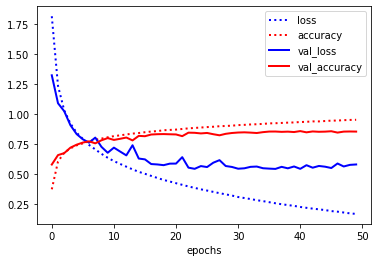

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1536)              4720128   
_________________________________________________________________
dense_7 (Dense)              (None, 768)               1180416   
_________________________________________________________________
dense_8 (Dense)              (None, 200)               153800    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2010      
Total params: 6,056,354
Trainable params: 6,056,354
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_1():
    # Create Sequential model
    model = models.Sequential()

    # Reshape the i

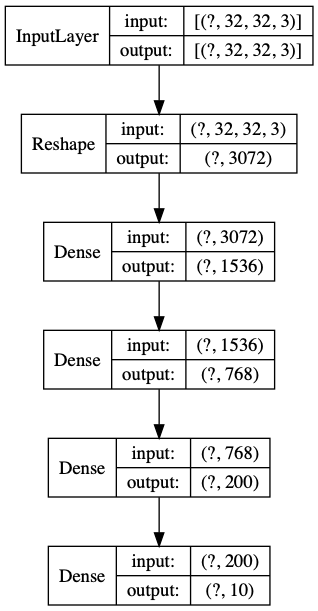

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

Compared to model_1_1,time per epoch is less due to less parameters. There is an increase in val_accurracy of 0.4%,but a decrease in accuracy of 0.8%,also smaller val_loss spikes. Thus less overfitting,as the val_accuracy is closer to the accuracy. Thus the model is performing better,as the val_accuracy is higher but also less costly to compute. Thus color introduces noice and the model is memorizing the noice less by gray-scaling. (length: 436)



Max val score: 86.22%


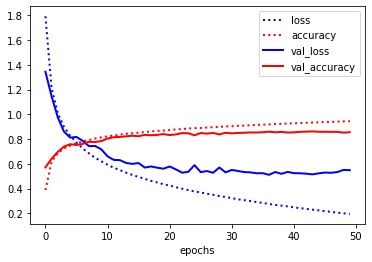

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1536)              1574400   
_________________________________________________________________
dense_11 (Dense)             (None, 768)               1180416   
_________________________________________________________________
dense_12 (Dense)             (None, 200)               153800    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2010      
Total params: 2,910,626
Trainable params: 2,910,626
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_2():
    # Create Sequential model
    model = models.Sequential()

    # Reshape the i

In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

A ridge regularizer gets better results than lasso, less overfitting.Other optimers,batch size or learing rate results in worse val_accuracy or heavy val_loss spikes. Batchnormalization has no effect and increasing dropout gives worse val_accuracy. Regularization does remove overfitting,but doesn't improve the model.The loss of training an val now decreases gradually. (length: 371)



Max val score: 86.02%


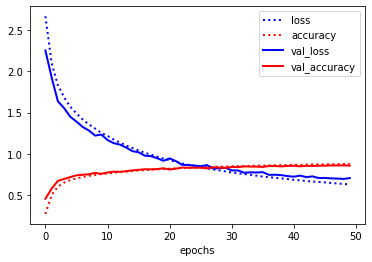

def build_model_1_3():
    # Create Sequential model
    model = models.Sequential()

    # Reshape the input based on gray-scaled images
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))

    # Add dense layers to model and dropout with BatchNormalization
    model.add(layers.Dense(1536, kernel_regularizer=regularizers.l2(0.00025), activation='relu'))
    model.add(layers.Dense(768, kernel_regularizer=regularizers.l2(0.00025), activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(200, kernel_regularizer=regularizers.l2(0.00025), activation='relu'))
    model.add(layers.Dropout(0.5))
    # Add softmax output layer
    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizers.Adagrad(lr=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    # Return model
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

This model uses blocks of conv layers with maxpooling and dropout after. The maxpooling after conv layers, helps to reduce the computations and extracting more dominant features, which helps with overfitting. To tackle the remaining overfitting, a gradually increasing dropout helps to reduce overfitting. This works as deep layers in the model reguralize more than layers close to input layer. Doubling the filter size in the conv blocks works best with last conv block having size 200,which results in the best results. Adding/removing conv layers results in worse results and kernal size 4x4 results in the best results. The model works well,but could have been stopped at epoch 15,as it start overfitting. (length: 710)



Max val score: 95.56%


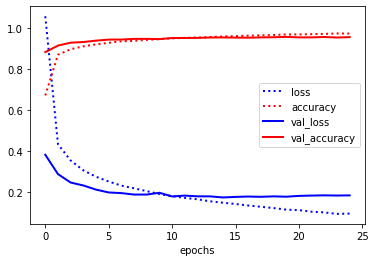

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 32, 32, 32)        544       
_________________________________________________________________
batch_normalization_67 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 32)        16416     
_________________________________________________________________
batch_normalization_68 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_86 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 16, 16, 64)      

def build_model_2_1():
  # Create Sequential model
  model = models.Sequential()

  # Reshape the input based on gray-scaled images
  model.add(layers.Conv2D(32, (4, 4), activation='relu', padding='same', input_shape=(32, 32, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (4, 4), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (4, 4), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (4, 4), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(200, (4, 4), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(200, (4, 4), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  m

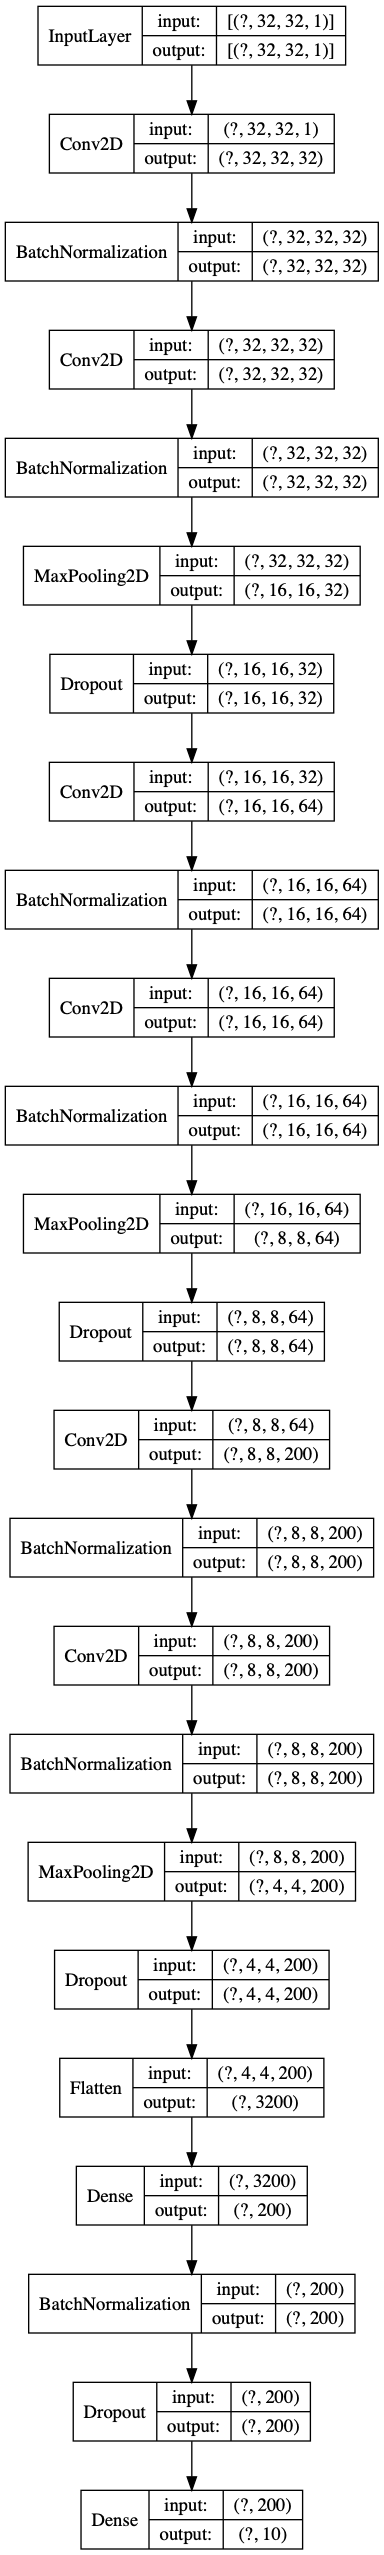

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

Bigger values for rotation,shift or zoom gives worse accuracy. Rescaling, brightness, zca_whitening, shear or zca_epsilon results in worse accuracy. A small augmentation improves the model slightly, it has more data to train on and a small augmentation could make a number more visible, while a larger change makes the image harder to recognize or changes the orientation, such as with flipping(9 becomes 6). (length: 409)



Max val score: 95.73%


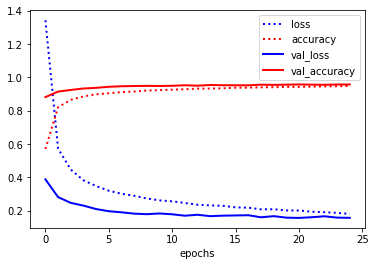


train_datagen = ImageDataGenerator(
    rotation_range= 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[1,1.25])


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

Some labels such as 1, appear more often than other numbers. 7 is predicted but 1 is expected often,25 times, also the other way around(1 pred,but actual 7). 3 is predicted, but 5 is expected 39 times and 2 is predicted while actual label 1 often. Interestingly, when expected 3,instead 5 is missclassified most often, while I expected 8, as they seem most alike. The model makes an error if First:The image quality is to bad, such that even humans can't label the image. Second:An image is cut of,such that it looks like another number. Third:Multiple numbers in the image and it picks the wrong number. Fourth:The model simply labels the image wrong. Fifth:The image is labeled wrong in the data/ actually represent other number. (length: 732)

Test score: 0.96%


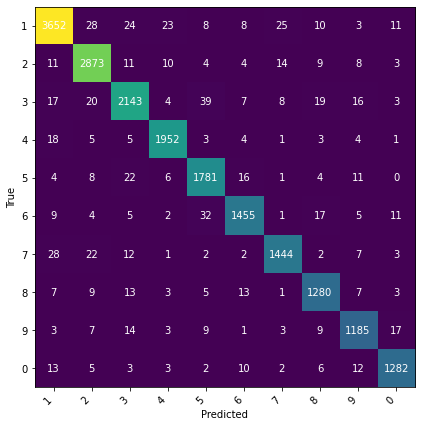

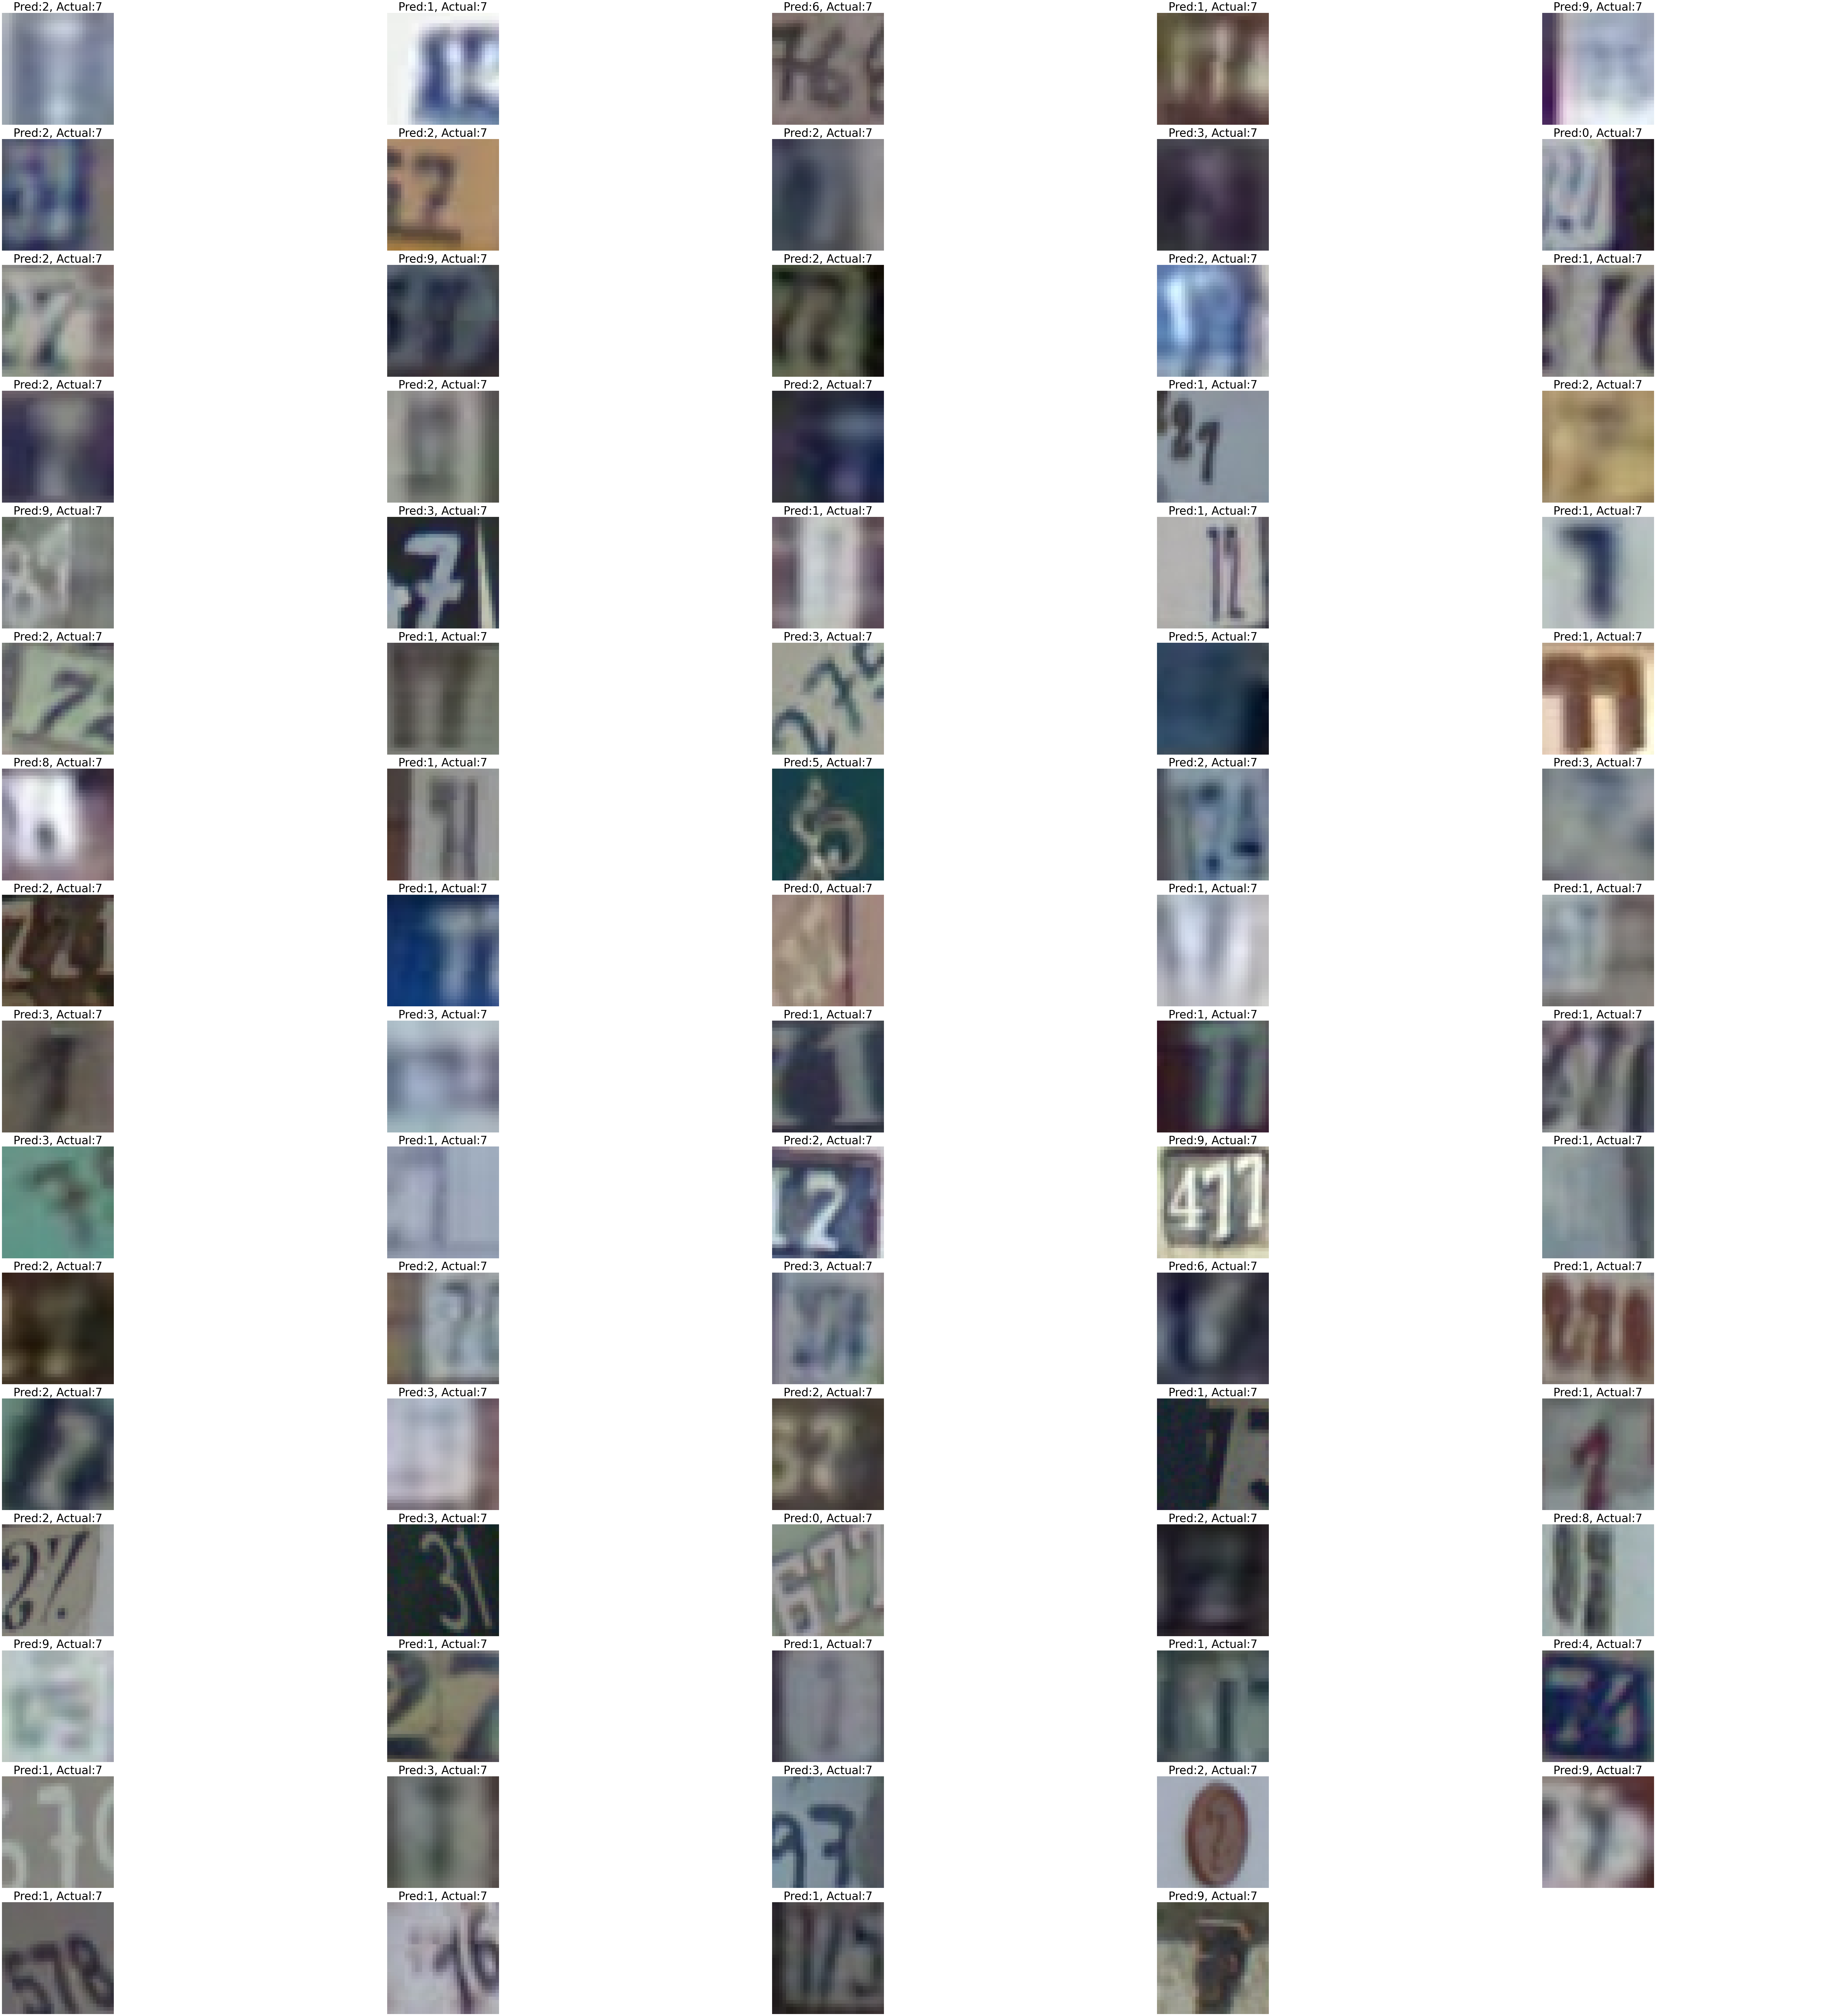

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

Some of the filters also don't respond in the 1st layer. The 2nd,3rd and 4th layer conv layer focus more on on patterns(vertical/horizontal). The 3rd conv layer seems to see clear holes of the 8 The last conv layers seems to learn more complex abstractions. It focusses more on the right edge of image. The model is definitely learning and recognizing the edges and holes of the 8. (length: 382)



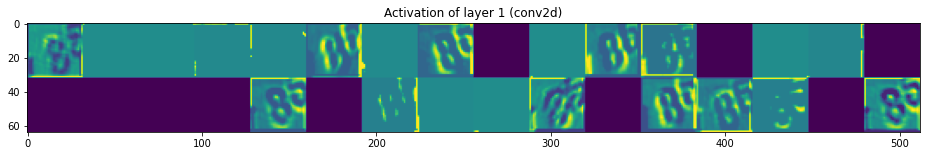

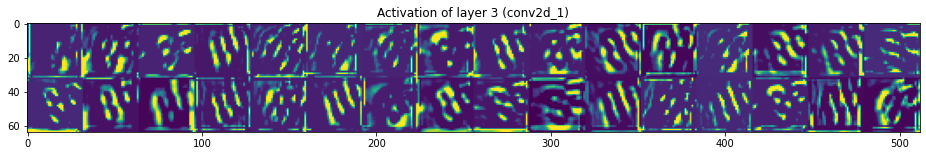

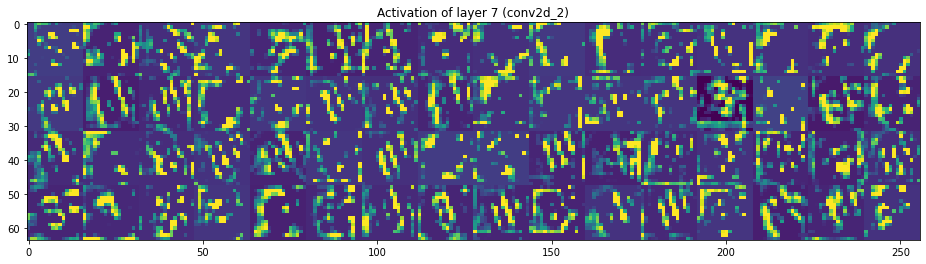

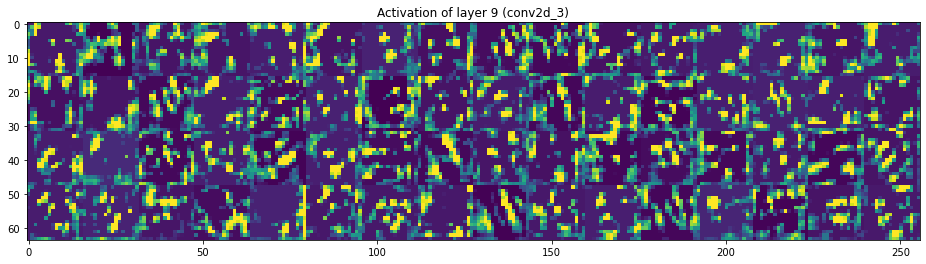

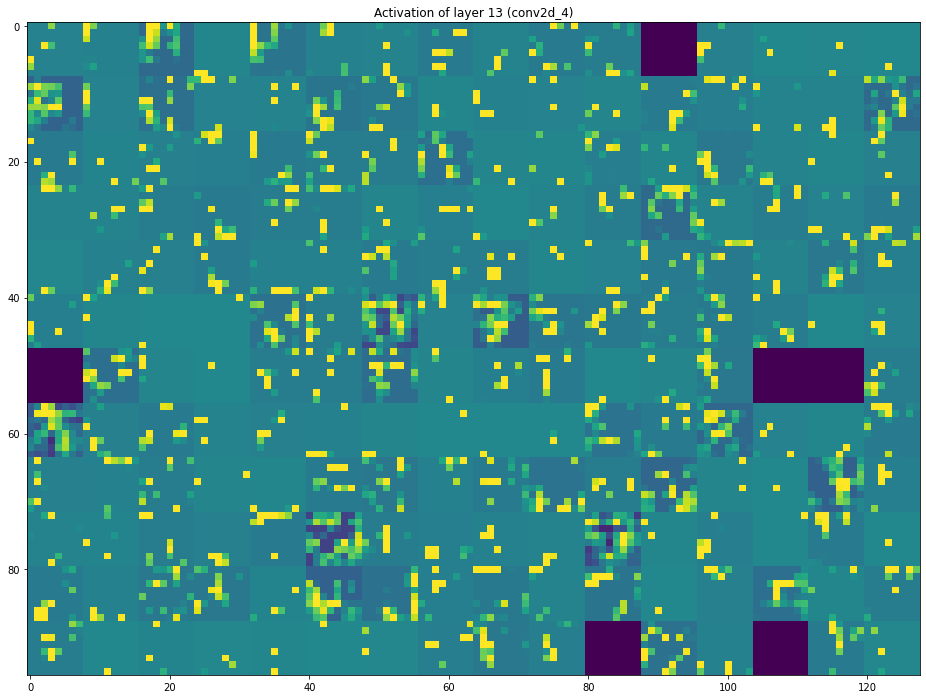

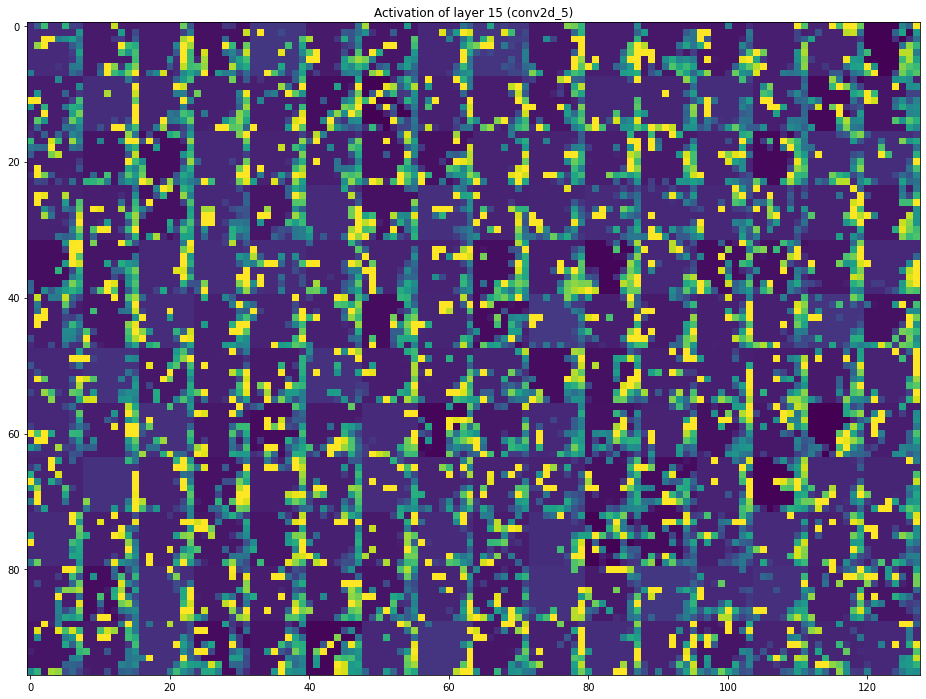

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

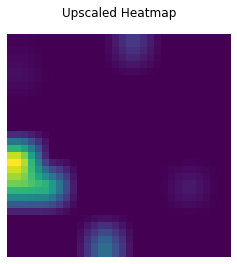

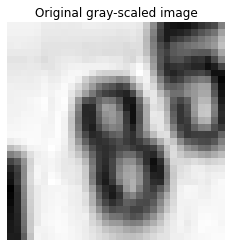

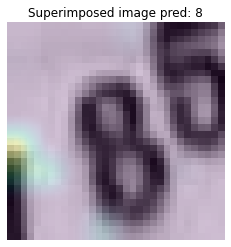

def plot_3_3():
  K.clear_session()

  # Load model 2_2
  model = load_model_from_file(base_dir, "model_2_2", extension='.h5')
  

  X_testGray = rgb2gray(X_test)
  
  # Do model prediction to get prediction of first image
  preds = model.predict(X_testGray)
  
  # Get predictions labels
  predictionsLabels = [(np.argmax(entry)+1)%10 for entry in preds]
  
  # Get gray-scaled image
  img_tensor = X_testGray[0]

  img_tensor = np.expand_dims(img_tensor, axis=0)

  # Get last conv layer conv2d_5
  last_conv_layer = model.get_layer('conv2d_5')

  first_output = model.output[:, 0]

  grads = K.gradients(first_output, last_conv_layer.output)[0]

  # Generate pooled grad values
  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  # given a sample image
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

  # for loop of 200, as this is the specified value for the last layer
  for i in range(200):


In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

Unfreezing model, gives best val_accuracy,95.5%,but ofcourse longest training time as we lose all trained weights. Unfreezing only last conv block,we still train half of the params,thus the model can use the last conv block to retrain some features. Compared to previous models with no regularization, the accuracy is the same,it does overfit heavily from epoch 6 onwards,so regularization should be applied. Unfreezing more layers results in better accuracy (length: 459)



Max val score: 83.91%


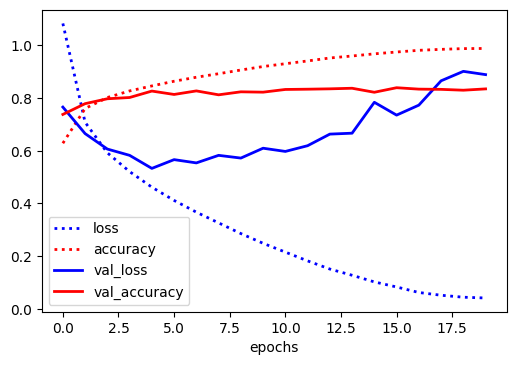

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

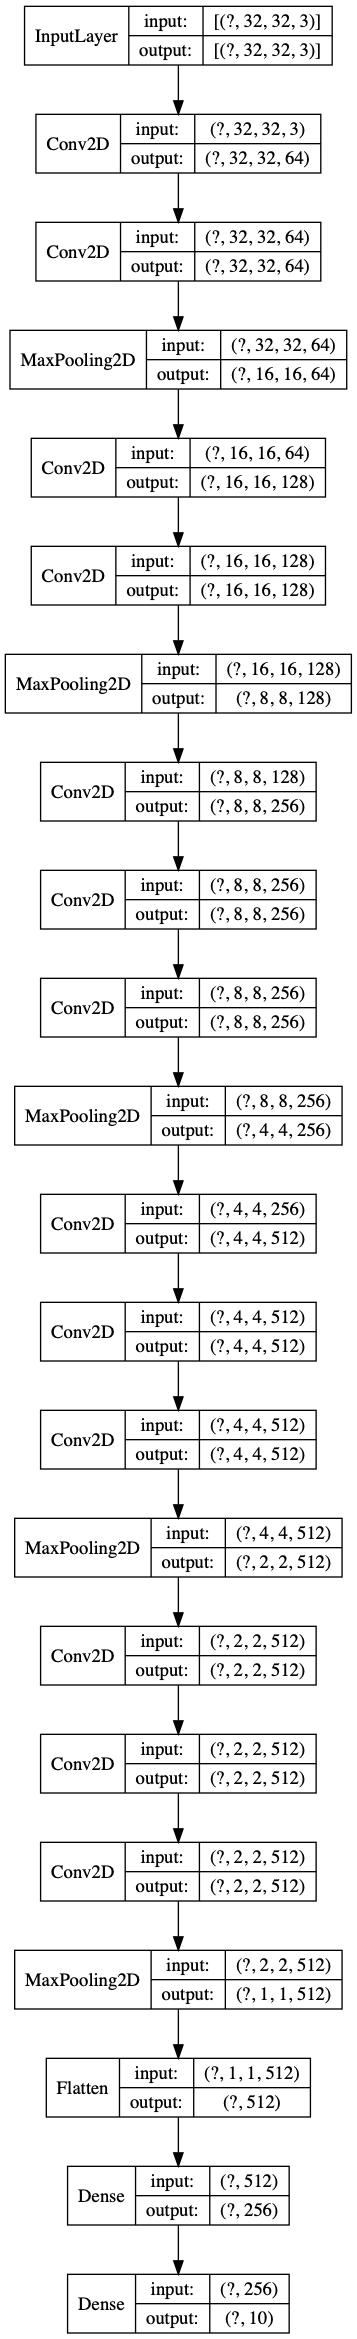

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

With the pipeline we evaluate the accuracy. We test classifiers/scalers on val set and then 'confirm' on the test set. Different scalers(MinMax,normalizer,Standard) have little effect on the result, same applies for different classifiers. RBF gives best results(84,2), than logisticRegression(84,1), than RandomForrest(84%), than KNN (83,5%), which also takes longer to train. Results are slightly better than model 4_4,but doesn't beat CNN. (length: 442)

Pipeline(steps=[('scaler', Normalizer()), ('svm', SVC())])
def store_embeddings():
  """ Stores all necessary embeddings to file
  """

  # Load model
  model = load_model_from_file(base_dir, "model_4_1", extension='.h5')
  
  # Get model output
  x = model.output

  # Define 'last' layer name and get that output of the model 4_1
  layer_name = 'block5_pool'
  intermediate_layer_model = tensorflow.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

  # Store embedding training
  embedding_train = intermediate_lay

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 165.35 seconds
Last modified: May 29, 2020
scikit-learn version: 0.23.1
